<img src="imagenes/rn3.png" width="200">
<img src="http://www.identidadbuho.uson.mx/assets/letragrama-rgb-150.jpg" width="200">

# [Curso de Redes Neuronales](https://curso-redes-neuronales-unison.github.io/Temario/)

# Una sola unidad *softmax*

[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/), 18 de febrero de 2019 (última revisión).

En esta libreta vamos a revisar los aspectos básicos del aprendizaje para una unidad *softmax* de $K$ salidas, sin capas ocultas y usando el criterio de pérdida de entropia en varias clases. El algoritmo es sencillo pero es importante entenderlo bien antes de pasar a cosas más complicadas.

Empecemos por inicializar los modulos que vamos a requerir.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('ggplot')

## 1. La base de datos a utilizar

La unidad *softmax* es el último de los tipos básicos de neuronas de salida que revisaremos. Para ejemplificar su uso, vamos a utilizar una base de datos bastante comun, MNIST. MNIST es una base de datos de digitos escritos a mano, en formato de $20 \times 20$ pixeles. La base completa puede obtenerse en la página de Yan LeCun (http://yann.lecun.com/exdb/mnist/).

Nosotros en realidad vamos a utilizar una base de datos reducida de la original y con imágenes de calidad más reducida ($16 \times 16$ pixeles por imagen). Numpy provée un método para guardad objetos tipo numpy en un solo archivo, utilizando el método de compresión *gunzip*. Los datos ya se encuentran preprocesados y empaquetados en un archivo llamado `digitos.npz`. 

In [2]:
data = np.load("datos/digitos.npz")

print("Las llaves del diccionario son: \n{}".format(data.keys()))

Las llaves del diccionario son: 
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f013c25a390>)


En este caso, `data` es un objeto contenedor de numpy cuyas llaves son `X_valida`, `X_entrena`, `T_valida`, `T_entrena`. Cada una de estas son a su vez objetos tipo ndarray de numpy, los cuales contienen valores de entrada y salida, tantopara entrenamiento como para validación. No se preocupen, esto de entrenamiento y validación lo vamos a ver más adelante en la clase.

Cada renglon de x es una imagen *desenrrollada*, esto es los 256 datos de una imágen de $16 \times 16$ pixeles. Por otra parte, cada renglon de y es un vector de 10 posiciones, donde todos los valores son ceros, salvo uno, que es el que define la clase de la imagen.

Para darse una mejor idea, ejecuta el siguiente script varias veces.

-- x es de dimensiones (9000, 256)
-- y es de dimensiones (9000, 10)

y si escogemos la imagen 4427 veremos


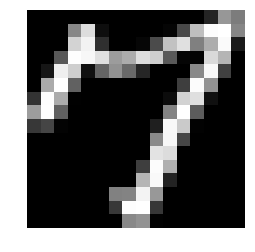

la cual es un 7


Y si miramos lo que contiene, veremos que
x[a,:] = 
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.14509805 0.59215689 0.48627454 0.         0.
 0.         0.52941179 0.86666673 0.05490196 0.         0.
 0.         0.         0.01960784 0.29019609 0.74509805 0.98823535
 1.         0.52549022 0.         0.         0.         0.83137262
 0.94901967 0.18431373 0.         0.         0.02352941 0.29411766
 0.76078439 0.87843144 0.50196081 0.67843139 0.98039222 0.10196079
 0.         0.         0.34509805 0.99607849 0.96862751 0.87843144
 0.61176473 0.67450982 0.86666673 0.80784321 0.35294119 0.01960784
 0.01176471 0.85098046 0.70980394 0.         0.         0.08627451
 0.93725497 0.80784321 0.0627451  0.3921569  0.57254905 0.41568631
 0.14901961 0.         0.         0.         0.53725493 0.97254908
 0.25098041 0.         0.         0.67058825 1.         0.38431376
 0.         0.         0

In [6]:
x = data['X_entrena']
y = data['T_entrena']

a = np.random.randint(0, y.shape[0])

print("-- x es de dimensiones {}".format(x.shape))
print("-- y es de dimensiones {}".format(y.shape))

print("\ny si escogemos la imagen {} veremos".format(a))

plt.imshow(x[a,:].reshape(16,16), cmap=plt.gray())
plt.axis('off')
plt.show()

print("la cual es un {}".format(list(y[a,:]).index(1)))

print("\n\nY si miramos lo que contiene, veremos que")
print("x[a,:] = \n{}\ny[a,:] = \n{}".format(x[a,:], y[a,:]))


O bien, ejecuta este script varias veces para ver un grupo grande de imágenes.

Text(0.5,1,'Ejemplos aleatorios de imágenes a clasificar')

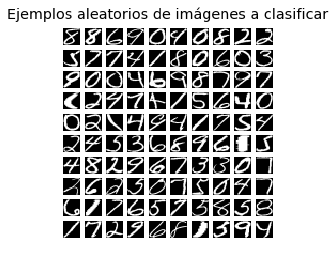

In [11]:
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
ind = indices[0:100].reshape(10,10)

imagen = np.ones((10 * 16 + 4*11, 10 * 16 + 4*11))
for i in range(10):
    for j in range(10):
        imagen[4 + i * 20: 20 + i * 20, 4 + j * 20: 20 + j * 20] = x[ind[i, j], :].reshape(16,16)
        
plt.imshow(imagen, cmap=plt.gray())
plt.axis('off')
plt.title(u"Ejemplos aleatorios de imágenes a clasificar")


## 2. Unidad *softmax*

En una unidad *softmax*, en lugar de estimar solamente un vector de parámetros, el valor de salida lo descomponemos en $K$ vectores de salida con valores de 1 (si pertenece a esa clase) o cero (si no pertenece). A esto se le conoce como *dummy variable*. En el ejemplo que tenemos, las clases ya se encuentran de esa forma (por eso la salida es un vector de dimensión 10 donde solo uno es 1 y todos los demás valores son 0).  

El problema de aprendizaje para una unidad *softmax* es estimar una matriz de pesos $W$ y un vector de sesgos tal que:

$$
W = (w_1, \ldots, w_K)^T, \quad b = (b_1, \ldots, b_K)^T
$$

donde $w_c = (w_{c,1}, \ldots, w_{c,n})^T$ para $c = 1, \ldots, K$, es el vector columna que parametriza la clase $c$. 
La probabilidad que el objeto $x^{(i)}$ pertenezca a la clase $c$ está dado por una distribución *softmax* de la agregación lineal de cada atributo, esto es:

$$
z_c^{(i)} = w_c^T x^{(i)} + b_c, \quad z^{(i)} = (z_1^{(i)}, \ldots, z_K^{(i)})^T,
$$

$$
a_c^{(i)} = \Pr[y^{(i)} = c\ |\ x^{(i)}; W, b] = softmax_c(z^{(i)}) = \frac{\exp(z_c^{(i)})}{\sum_{r=1}^K \exp(z_r^{(i)})}.
$$

Recuerda que para calcular el valor de *softmax* hay que estar muy pendiente de evitar problemas de estabilidad numérica, así que cuando lo programes toma en cuenta las recomedaciones que se realizaron en el curso.

**Implementa el calculo de softmax en forma matricial (para todas las clases de un conjunto de M ejemplos)**


In [12]:
def softmax(z):
    """
    Calculo de la regresión softmax
    
    @param z: ndarray de dimensión (K, M) donde z[:, i] es el vector $z^{(i)}$
    
    @return: un ndarray de dimensión (K, M) donde cada columna es $a^{(i)}$.
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    a = np.exp(z - np.amax(z, axis=0))
    return np.divide(a, np.sum(a, axis=0) )
    
    
    
    #--------------------------------------------------------------------------------

# Y otra vez con el testunit del pobre (los pueden hacer a mano para verificar)
z = np.array([[    1,    -10,     -10],
              [    0,      0,       0],
              [-1000,  -1000,   -1000],
              [   10,    -20,     -21],
              [    1,    0.5,    0.9]]).T
a = softmax(z)

print(a)

assert np.all(np.abs(np.sum(a, axis=0) - 1) < 1e-8)
assert a[0, 0] > 0.999
assert a[1, 0] == a[2, 0]
assert 0.33 < a[0, 1] == a[1, 1] == a[2, 1] < 0.34
assert 0.33 < a[0, 2] == a[1, 2] == a[2, 2] < 0.34
assert a[1, 3] > a[2, 3]
assert a[1, 4] < a[2, 4] < a[0, 4]


[[9.99966598e-01 3.33333333e-01 3.33333333e-01 1.00000000e+00
  3.98189341e-01]
 [1.67011429e-05 3.33333333e-01 3.33333333e-01 9.35762297e-14
  2.41514044e-01]
 [1.67011429e-05 3.33333333e-01 3.33333333e-01 3.44247711e-14
  3.60296615e-01]]


Y ahora es necesario implementar la función de pérdida, la cual es la suma del logaritmo de la probabilidad estimada para la clase que debería haber sido seleccionada (criterio de mínima entropía) tal como lo vimos en clase:

$$
Loss(W, b) = -\frac{1}{M}\sum_{i=1}^M \sum_{c=1}^K y_c^{(i)} \log(a_c^{(i)}),
$$

donde $y_c^{(i)}$ es un valor de 0 o 1 dependiendo si el objeto $i$ pertenece a la clase $c$ o no, mientras que $a_c^{(i)}$ es la probabilidad que el objeto $i$ pertenezca a la clase $k$ conociendo $x^{(i)}$ y parametrizado por W y b. 

**Implementa la función de pérdida de manera relativamente eficiente, utilizando las facilidades que presenta numpy (recuerda usar los trucos vistos para el cálculo del logarítmo de la función softmax).**

In [14]:
def Loss(x, y, W, b):
    """
    Calcula el costo para la regresión softmax parametrizada por theta, 
    con el conjunto de datos dado por (x, y)
    
    @param x: ndarray de dimensión (M, n) con los datos
    @param y: ndarray de dimensión (M, K) con la clase por cada dato
    @param W: ndarray de dimensión (K, n) con los pesos
    @param b: ndarray de dimensión (K,) con los sesgos
    
    @return: Un valor flotante con la pérdida utilizando mínima entropía
    
    """
    M, K = y.shape
    n = x.shape[1]
    
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    z = x @ W.T + b 
    a = np.log(softmax(z.T)) 
    return -1 / M * np.sum(y * a.T)
    
    
    
    #--------------------------------------------------------------------------------

def test_perdida():
    x = np.array([[0, 0], 
                  [0, 1], 
                  [1, 0], 
                  [1, 1]])

    y = np.eye(4)

    W = np.array([[-4,  -4],
                  [-1,   3],
                  [ 3, -10],
                  [ 5,   5]])
                
    b = np.array([3, -1, 0.01, -5])
    
    #print(Loss(x, y, W, b))
    
    assert 0.08 < Loss(x, y, W, b) < 0.09
    return "Paso la prueba"
    
print(test_perdida())

Paso la prueba


**Implementa la función para predecir el valor de $y$ estimada, basandose en el principio de *maximum a posteriori.**

In [19]:
def predice(x, W, b):
    """
    Prediccion de y_hat a partir de la matriz de pesos W y el vector de sesgos b 
    para los valores de x
    
    @param x: ndarray de dimensión (M, n) con los datos
    @param W: ndarray de dimensión (K, n) con los pesos
    @param b: ndarray de dimensión (K, ) con los sesgos

    @return: ndarray de dimensión (M, K) con la clase predecida 
             por cada dato en formato dummy (unos y ceros)
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--a-----------------------------------------------------------------------------
    z = x @ W.T + b  # (M,K)
    return softmax(z.T).T >= 0.5
    
    #--------------------------------------------------------------------------------

def prueba_prediccion():
    x = np.array([[0, 0], 
                  [0, 1], 
                  [1, 0], 
                  [1, 1],
                  [0, 0], 
                  [0, 1], 
                  [1, 0], 
                  [1, 1]])
    
    y = np.r_[np.eye(4), np.eye(4)]
    
    W = np.array([[-4,  -4],
                  [-1,   3],
                  [ 3, -10],
                  [ 5,   5]])

    b = np.array([3, -1, 0.01, -5])
        
    assert abs((y - predice(x, W, b)).sum()) < 1e-12 
    print("Paso la prueba")
    
prueba_prediccion()

Paso la prueba


Y por último tenemos que implementar el gradiente para poder utilizar los métodos de optimización (ya sea por descenso de gradiente o por algún método de optimización.

El gradiente se obtiene a partir de las derivadas parciales:

$$
\frac{\partial Loss(W, b)}{\partial w_{c,j}} = - \frac{1}{M} \sum_{i = 1}^M \left(y_c^{(i)} - a_c^{i}\right) x_j^{(i)}, \qquad \frac{\partial Loss(W, b)}{\partial b_c} = - \frac{1}{M} \sum_{i = 1}^M \left(y_c^{(i)} - a_c^{i}\right)
$$

**Implementa una función para el cálculo del gradiente.**

In [49]:
def gradiente(x, y, W, b):
    """
    Calculo del gradiente para el problema de regresión softmax
    
    @param x: ndarray de dimensión (M, n) con los datos
    @param y: ndarray de dimensión (M, K) con la clase (dummy) por cada dato
    @param W: ndarray de dimensión (K, n) con los pesos
    @param b: ndarray de dmensión (K, ) con los sesgos
    
    @return: dW, db con los gradientes de Loss respecto a W y b respectivamente
    
    """
    M = x.shape[0]
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    z = x @ W.T + b  
    a = softmax(z.T) 
    dW = -1 / M * ((y.T - a) @ x)  # (K, M) - (K, M) = (K, M) @ (M, n) = (K, n)
    db = -1 / M * (np.sum(y.T - a, axis=1))
    #--------------------------------------------------------------------------------
    return dW, db

def prueba_gradiente():
    
    x = np.array([[0, 0], 
                  [0, 1], 
                  [1, 0], 
                  [1, 1]])
    
    y = np.eye(4)

    W = np.array([[-4,  -4],
                  [-1,   3],
                  [ 3, -10],
                  [ 5,   5]])

    b = np.array([3, -1, 0.01, -5])


    dW, db = gradiente(x, y, W, b)
    
    assert dW.shape == W.shape
    assert db.shape == db.shape
    assert np.all(np.abs(db - np.array([-0.001, -0.028, -0.005, 0.035])) < 0.001)
    assert -0.0304 < dW.trace() < -0.0302

    print("Paso la prueba")
    
prueba_gradiente() 
    
    

Paso la prueba


Ahora si, ya nos encontramos en posibilidad para realizar el aprendizaje en una unidad softmax.

**Desarrolla el aprendizaje por descenso de gradiente (similaral de las otras libretas)**.

In [43]:
def dg_softmax(x, y, W, b, alpha, max_iter=10000, tol=1e-3, historial=False):
    """
    Descenso de gradiente por lotes para la clasificación softmax
    
    ---AGREGA AQUI LA DOCUMENTACIÓN---
    
    """
    if historial:
        historial_loss = np.zeros(max_iter)
        historial_loss[0] = Loss(x, y, W, b)
    else:
        historial_loss = None
            
    for iter in range(1, max_iter):
        #--------------------------------------------------------------------------------
        # AGREGA AQUI TU CÓDIGO
        #--------------------------------------------------------------------------------
        dW, db = gradiente(x, y, W, b)
        W -= alpha * dW
        b -= alpha * db
        loss = Loss(x, y, W, b)
        if historial:
            historial_loss[iter] = loss
        
        
        
        
        
        #--------------------------------------------------------------------------------
    return W, b, historial_loss
        
    

Pero para utilizar el descenso de gradiente hay que ajustar un valor de `alpha`.

0.18754832606836394


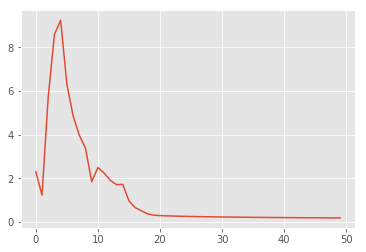

In [44]:
# Ajusta un valor de epsilon razonable

alpha_prueba = 5#---usa esto para buscar un valor aceptable de alpha---

M, K = y.shape
n = x.shape[1]

W = np.zeros((K, n))
b = np.zeros(K)

_, _, loss_hist = dg_softmax(x, y, W, b, alpha_prueba, max_iter=50, historial=True)
print(loss_hist[-1])
plt.plot(range(50), loss_hist)



y para probarlo vamos a aprender a clasificar a los digitos de nuestra base de datos


In [50]:
W = np.zeros((K, n))
b = np.zeros(K)

alpha = alpha_prueba
W, b, _ = dg_softmax(x, y, W, b, alpha, max_iter=3000)

print("El costo de la solución final es de {}".format(Loss(x, y, W, b)))

y_estimada = predice(x, W, b)
errores = np.where(y.argmax(axis=1) == y_estimada.argmax(axis=1), 0, 1)
print("\nLos datos utilizados para el aprendizaje y mal clasificados son el {}%,".format(100 * errores.mean()))
print("esto es, de {} datos, se clasificaron incorrectamente {}".format(x.shape[0], errores.sum()))

# Esto solo es para hacerla más emocionante
x_test = data['X_valida']
y_test = data['T_valida']
y_estimada_T = predice(x_test, W, b)
errores = np.where(y_test.argmax(axis=1) == y_estimada_T.argmax(axis=1), 0, 1)

print("\nY con los datos de pureba el error es del {}%,".format(100 * errores.mean()))
print("esto es, de {} datos, se clasificaron incorrectamente {}".format(x_test.shape[0], errores.sum()))



El costo de la solución final es de 0.05161328042293556

Los datos utilizados para el aprendizaje y mal clasificados son el 1.2333333333333334%,
esto es, de 9000 datos, se clasificaron incorrectamente 111

Y con los datos de pureba el error es del 6.1%,
esto es, de 1000 datos, se clasificaron incorrectamente 61


¿Será esta la mejor solución? ¿Será una buena solución? Por esto no hay que preocuparse mucho todavía, lo vamos a revisar más adelante en el curso. Se espera con la unidad *softmax* poder clasificar correctamente más del 97% de los datos de entrenamiento y más del 94% de los datos de validación. 